In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.chdir('Transformer-MM-Explainability')
os.chdir('ConvT-explain')

In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets

# from DETR.datasets.coco import *
import torch
import torchvision.transforms as T
import os
import random
import cv2
import DETR.util.misc as utils

from DETR.models import build_model
from DETR.modules.ExplanationGenerator import Generator
import argparse

In [3]:
import DETR.models

In [4]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        # COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes, line_width=3, font_size=10):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=line_width))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=font_size,
                bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.show()

In [5]:
def detect(im, model, confidence=0.7):
    img=transform(im).unsqueeze(0).to(device)

    outputs=model(img)
    
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > confidence

    # 0과 1사이의 boxes 값을 image scale로 확대합니다.
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)
    scores, boxes=probas[keep], bboxes_scaled
    
    return scores, boxes
    

### Evaluate function from Analysis across heads.ipynb

In [6]:
def evaluate(model, gen, im, device, image_id=None, show_all_layers=False, show_raw_attn=False):

    # 평균-분산 정규화 (train dataset의 통계량을 (test) input image에 사용
    img=transform(im).unsqueeze(0).to(device)
    
    # model 통과
    outputs =model(img)
    
    # 정확도 70% 이상의 예측만 사용
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1] # background 제외
    keep = probas.max(-1).values > 0.7
    
    if keep.nonzero().shape[0] <=1 : # detect된 object
        return
    
    
    # 원래 cuda에 적재되어있던 좌표들
    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()
    
    # [0,1]의 상대 좌표를 원래의 좌표로 복구
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)


    #attention weight 저장
    
    hooks=[]
#     conv_features_in, enc_attn_in, dec_attn_in = [], [], []
    conv_features_out, enc_attn_out, dec_attn_out = [], [], []

#     # 이 때, output[0] : [token, 1, hidden_dim] --> 토큰
#     # output[1] : [1, token, token] --> 가중치
       
#     ## Cnv
#     # in
#     for layer_name in model.backbone[-2].body:
#         hook=model.backbone[-2].body[layer_name].register_forward_hook(
#         lambda self, input, output : conv_features_in.append(input)
#         )
#         hooks.append(hook)
    
#     hook=model.backbone[-1].register_forward_hook(
#     lambda self, input, output : conv_features_in.append(input))
    #out
    for layer_name in model.backbone[-2].body:
        hook=model.backbone[-2].body[layer_name].register_forward_hook(
        lambda self, input, output : conv_features_out.append(output)
        )
        hooks.append(hook)
    
#     hook=model.backbone[-1].register_forward_hook(
#     lambda self, input, output : conv_features_out.append(output))
            
#     # transformer encoder 내 모든 layer의 output 저장
#     # default : (enc_layer = 6)
    
#     ## encoder
#     # in
#     for layer in model.transformer.encoder.layers:
#         hook=layer.self_attn.register_forward_hook(
#         lambda self, input, output : enc_attn_in.append(input)
#         )
#         hooks.append(hook)
        
        
        
#     # out    
#     for layer in model.transformer.encoder.layers:
#         hook=layer.self_attn.register_forward_hook(
#         lambda self, input, output : enc_attn_out.append(output)
#         )
#         hooks.append(hook)
        
        
#     ## decoder
#     # in
#     for layer in model.transformer.decoder.layers:
#         hook=layer.self_attn.register_forward_hook(
#         lambda self, input, output : dec_attn_in.append(input)
#         )
#         hooks.append(hook)
#     # out
#     for layer in model.transformer.decoder.layers:
#         hook=layer.self_attn.register_forward_hook(
#         lambda self, input, output : dec_attn_out.append(output)
#         )
#         hooks.append(hook)
#     # 모델 통과(및 저장)
    model(img)
    
# #     return enc_attn_weights
#     # hook 제거
    for hook in hooks:
        hook.remove()
    
    # 리스트는 필요 없다.
    # 우선 위의 for문을 통해 encoder layer의 모든 가중치를 저장은 해놨으나,
    # 여기서는 encoder의 마지막 layer만을 사용하자.
#     conv_features = conv_features[0] # feature-map
#     enc_attn_weights = enc_attn_weights[-1] # 마지막 encoder layer의 가중치만 사용 (256개의 값)
#     dec_attn_weights = dec_attn_weights[0] # 마지막 decoder layer의 가중치만 사용 (256개의 값)
    
    #  get the shape of feature map
#     return conv_features
    print(conv_features_out)
    h, w = conv_features_out[-1].shape[-2:] # Nested tensor -> tensors
# #     img_np = np.array(im).astype(np.float)
    if not show_all_layers == True:
        fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22,7))
    else:
        n_layers=len(model.transformer.encoder.layers)
        if not show_raw_attn:
            fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=n_layers+1, figsize=(22, 4*n_layers))
        else:
            fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=model.transformer.nhead+1,
                                    figsize=(22, 4*model.transformer.nhead))
    # object queries는 100차원(default)이기 때문에 그 중에 
    # 0.7(default) 이상의 신뢰도를 보이는 query만을 사용해야 한다. 
    
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        
        ax = ax_i[0]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin.detach(), ymin.detach()), 
                                  xmax.detach() - xmin.detach(),
                                   ymax.detach() - ymin.detach(), 
                                   fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
        
      
        
        if not show_all_layers == True:
            ax = ax_i[1]
                            
            
            cam = gen.generate_ours(img, idx, use_lrp=False)
            cam = (cam - cam.min()) / (cam.max() - cam.min()) # 점수 정규화
            cmap = plt.cm.get_cmap('Blues').reversed()

            ax.imshow(cam.view(h, w).data.cpu().numpy(), cmap=cmap)
            ax.axis('off')
            ax.set_title(f'query id: {idx.item()}')
        else:
            
            if not show_raw_attn:    
                cams = gen.generate_ours(img, idx, use_lrp=False, use_all_layers=True)
            else:
                cams = gen.generate_raw_attn(img, idx, use_all_layers=True)
            
            num_layer=n_layers
            if show_raw_attn:
                num_layer=model.transformer.nhead
            for n, cam in zip(range(num_layer), cams):
                ax = ax_i[1+n]
                cam = (cam - cam.min()) / (cam.max() - cam.min()) # 점수 정규화
                cmap = plt.cm.get_cmap('Blues').reversed()

                ax.imshow(cam.view(h, w).data.cpu().numpy(), cmap=cmap)
                ax.axis('off')
                ax.set_title(f'query id: {idx.item()}, layer:{n}', size=12)

### Expalnation function from *Analysis across heads.ipynb*

In [7]:
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1]) # 굳이?
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1]) # 굳이?
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0) # 음수를 제거한 다음 heads 차원을 따라 평균
    return cam 

# 식 (6), (7)
# 증가분을 반환합니다(위 식의 뒤쪽 항)
def apply_self_attention_rules(R_ss, R_sq, cam_ss):
    R_sq_addition = torch.matmul(cam_ss, R_sq)
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition, R_sq_addition

# 식 (10)
# bi-modal에 대한 aggregation rule
def apply_mm_attention_rules(R_ss, R_qq, cam_sq, apply_normalization=True,
                            apply_self_in_rule_10=True):
    R_ss_normalized = R_ss
    R_qq_normalized = R_qq
    
    if apply_normalization:
        R_ss_normalized = handle_residual(R_ss)
        R_qq_normalized = handle_residual(R_qq)
    R_sq_addition = torch.matmul(R_ss_normalized.t(), torch.matmul(cam_sq, R_qq_normalized))
    if not apply_self_in_rule_10:
        R_sq_addition = cam_sq
    R_sq_addition[torch.isnan(R_sq_addition)] = 0
    return R_sq_addition

# normalization- eq. 8+9
# 이 경우 Identity 행렬을 빼고 순수한 R에 대해서만 노말라이제이션합니다. 
def handle_residual(orig_self_attention):
    self_attention = orig_self_attention.clone()
    diag_idx = range(self_attention.shape[-1])
    self_attention -= torch.eye(self_attention.shape[-1]).to(self_attention.device) # Identity
    assert self_attention[diag_idx, diag_idx].min() >= 0 # 대각행렬
    self_attention = self_attention / self_attention.sum(dim=-1, keepdim=True)
    self_attention += torch.eye(self_attention.shape[-1]).to(self_attention.device)
    return self_attention

In [8]:
class Generator:
    def __init__(self, model):
        print('### Generator.init()')
        self.model = model
        self.model.eval() # evaluate 시 dropout, batchnorm 등은 사용하지 않는다.
        self.use_all_layers=False
        self.use_all_layers=False
        

    def forward(self, input_ids, attention_mask):
#         print('### Generator.forward(input_ids, attention_mask)')
        return self.model(input_ids, attention_mask)

    def generate_transformer_att(self, img, target_index, index=None):
        outputs = self.model(img)
        kwargs = {"alpha": 1,
                  "target_index": target_index}

        if index == None:
            index = outputs['pred_logits'][0, target_index, :-1].max(1)[1]

        kwargs["target_class"] = index

        one_hot = torch.zeros_like(outputs['pred_logits']).to(outputs['pred_logits'].device)
        one_hot[0, target_index, index] = 1
        one_hot_vector = one_hot.clone().detach()
        one_hot.requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * outputs['pred_logits'])

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(one_hot_vector, **kwargs)

        decoder_blocks = self.model.transformer.decoder.layers
        encoder_blocks = self.model.transformer.encoder.layers

        # initialize relevancy matrices
        image_bboxes = encoder_blocks[0].self_attn.get_attn().shape[-1]
        queries_num = decoder_blocks[0].self_attn.get_attn().shape[-1]

        # image self attention matrix
        self.R_i_i = torch.eye(image_bboxes, image_bboxes).to(encoder_blocks[0].self_attn.get_attn().device)
        # queries self attention matrix
        self.R_q_q = torch.eye(queries_num, queries_num).to(encoder_blocks[0].self_attn.get_attn().device)
        # impact of image boxes on queries
        self.R_q_i = torch.zeros(queries_num, image_bboxes).to(encoder_blocks[0].self_attn.get_attn().device)

        # R_q_i generated from last layer
        decoder_last = decoder_blocks[-1]
        cam_q_i = decoder_last.multihead_attn.get_attn_cam().detach()
        grad_q_i = decoder_last.multihead_attn.get_attn_gradients().detach()
        cam_q_i = avg_heads(cam_q_i, grad_q_i)
        self.R_q_i = cam_q_i
        aggregated = self.R_q_i.unsqueeze_(0)

        aggregated = aggregated[:, target_index, :].unsqueeze_(0)
        return aggregated

    def handle_self_attention_image(self, blocks):
        for blk in blocks:
            grad = blk.self_attn.get_attn_gradients().detach() # [8 x wh x wh]의 gradient(당연히 가중치랑 같음)
            if self.use_lrp: # 타당성 전파 시
                cam = blk.self_attn.get_attn_cam().detach() # [8 x wh x wh]의 cam(*)
            else:
                cam = blk.self_attn.get_attn().detach()
            cam = avg_heads(cam, grad)  # [wh x wh]의 averaged cam
            
            
            self.R_i_i += torch.matmul(cam, self.R_i_i)# [wh x wh] X [wh x wh]
            
            if self.use_all_layers == True:
                self.R_i_i_all.append(self.R_i_i.detach().clone())
                
    def handle_co_attn_self_query(self, block):
        grad = block.self_attn.get_attn_gradients().detach()
        if self.use_lrp:
            cam = block.self_attn.get_attn_cam().detach()
        else:
            cam = block.self_attn.get_attn().detach()
        cam = avg_heads(cam, grad)
        R_q_q_add, R_q_i_add = apply_self_attention_rules(self.R_q_q, self.R_q_i, cam) # 식 (6)(7), 행렬곱
        self.R_q_q += R_q_q_add
        self.R_q_i += R_q_i_add
        
        if self.use_all_layers == True:
            self.R_q_q_all.append(self.R_q_q.detach().clone())

    def handle_co_attn_query(self, block):
        if self.use_lrp:
            cam_q_i = block.multihead_attn.get_attn_cam().detach()  # multihead
        else:
            cam_q_i = block.multihead_attn.get_attn().detach()
        grad_q_i = block.multihead_attn.get_attn_gradients().detach()
        cam_q_i = avg_heads(cam_q_i, grad_q_i) # = [100 x wh]
        self.R_q_i += apply_mm_attention_rules(self.R_q_q, self.R_i_i, cam_q_i, # 식 (10), 행렬곱(R_ii x cam xi R_q_q)
                                               apply_normalization=self.normalize_self_attention, # R_qq, R_ii 정규화
                                               apply_self_in_rule_10=self.apply_self_in_rule_10) # R_sq 대신 cam_sq (*)
        if self.use_all_layers == True:
            self.R_q_i_all.append(self.R_q_i.detach().clone())
    def generate_ours(self, img, target_index, index=None, use_lrp=True,
                     normalize_self_attention=True, apply_self_in_rule_10=True, use_all_layers=False):
        

        self.use_lrp = use_lrp
        self.normalize_self_attention = normalize_self_attention
        self.apply_self_in_rule_10 = apply_self_in_rule_10
        self.use_all_layers = use_all_layers

        outputs = self.model(img)
        outputs = outputs['pred_logits']
        

        kwargs = {"alpha": 1, 
                 "target_index": target_index}
        
        if index == None:
            index = outputs[0, target_index, :-1].max(1)[1]

        kwargs["target_class"] = index
        
        one_hot = torch.zeros_like(outputs).to(outputs.device)
        one_hot[0, target_index, index] = 1 # [1, 100, 92] 차원으로 된 원핫벡터
        one_hot_vector = one_hot # 나중에 타당성 전파하기 위함

        one_hot.requires_grad_(True) # 그래디언트 추적 # 복사 후 원본은 다시 autograd가 추적해야 한다.
        one_hot = torch.sum(one_hot.cuda() * outputs)
        
       
        
        self.model.zero_grad() # 모델 내 그래디언트를 0으로 초기화

        one_hot.backward(retain_graph=True) # backward를 하는 동안에 중간 가중치들은 보존한다.
        
        
        if use_lrp:
            return 

            self.model.relprop(one_hot_vector, **kwargs)

        decoder_blocks = self.model.transformer.decoder.layers
        encoder_blocks = self.model.transformer.encoder.layers

        # 픽셀 개수
        image_bboxes = encoder_blocks[0].self_attn.get_attn().shape[-1] # wh in (8, wh, wh)
        # object 개수
        queries_num = decoder_blocks[0].self_attn.get_attn().shape[-1] # 100 in (8,100,100)
        # 타당성 행렬(Relevancy matrices) 초기화
        # 또한, 계산 자체가 attention weights랑 행해지기 때문에 device 맞춰주기
        # image self attention matrix - (wh x wh) 크기의 Identity 행렬
        self.R_i_i = torch.eye(image_bboxes, image_bboxes).to(encoder_blocks[0].self_attn.get_attn().device)
        
        # queries self attention matrix
        self.R_q_q = torch.eye(queries_num, queries_num).to(encoder_blocks[0].self_attn.get_attn().device)
        # image --> queries의 영향 ( (100 x wh) 크기 행렬)
        self.R_q_i = torch.zeros(queries_num, image_bboxes).to(encoder_blocks[0].self_attn.get_attn().device)
        
        if self.use_all_layers == True:
            self.R_i_i_all = []
            self.R_q_q_all = []
            self.R_q_i_all = []
        
         # encoder 내에서 image에 대한 self-attention

        self.handle_self_attention_image(encoder_blocks)
    
        # decoder 내에서 queries에 대한 self-attention + Multi-modal attention

        for idx, blk in enumerate(decoder_blocks):
            # decoder self attention
            self.handle_co_attn_self_query(blk)

            # encoder decoder attention
            self.handle_co_attn_query(blk)
      
        
        if not self.use_all_layers:
            aggregated = self.R_q_i.unsqueeze_(0)
            aggregated = aggregated[:,target_index, :].unsqueeze_(0).detach()
            # 결과적으로 위 타겟에 대한 [1, 1, 1, wh] 크기의 cam(if not use_all_layers)
            # 굳이 이렇게 만드는 이유는 아마 [layer, target_index, ...] 를 위해?            
        else:
            # [6, 1, 100, wh]

            aggregated = torch.stack(self.R_q_i_all).unsqueeze_(1)
            # [6, 1, 1, 1, wh]
            aggregated = aggregated[:, :, target_index, :].unsqueeze_(1).detach()

        
        
        return aggregated 

    
    def generate_raw_attn(self, img, target_index, use_all_layers=False):
        outputs = self.model(img)
        
        
        
        # get cross attn cam from last decoder layer
        cam_q_i = self.model.transformer.decoder.layers[-1].multihead_attn.get_attn().detach()
        cam_q_i = cam_q_i.reshape(-1, cam_q_i.shape[-2], cam_q_i.shape[-1])
        #         
        if use_all_layers:
            self.R_q_i_all = cam_q_i
            aggregated = self.R_q_i_all.unsqueeze_(1)
            aggregated = aggregated[:, :,  target_index, :].unsqueeze_(1)
        else : 
            cam_q_i = cam_q_i.mean(dim=0)
            self.R_q_i = cam_q_i
            aggregated = self.R_q_i.unsqueeze_(0)

            aggregated = aggregated[:, target_index, :].unsqueeze_(0)


        return aggregated

# 1. Add Interference to each heads

> Transformer-Decoder의 마지막에 decoder의 outputs 중 일부를 Off 하는 layer를 추가해주자.

> 우선, Attention 연산이 행해진 다음, attn_weight를 저장하기 전에 일부 head를 off 해주자. 
> 그 다음, (0928) : 연산이 행해지기 전에 attn_weight를 off 해주자.

In [38]:
class MultiheadAttention(RelProp): # in layers.py
    ...

    def __init__(self, embed_dim, num_heads, dropout=0., no_weight:'[num_heads] idx vector'=False): #수정-0927:Deocder attention off
        ...

        self.attn_gradients = None
        self.no_weight = no_weight #수정-0927:Deocder attention off

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):

       ...
        
        # 추가-0927:Deocder attention off
        if self.no_weight: # self.no_weight : length : multiheads. ex) [0,1,0,1,1,0,0,0] --> 2,4,5th head off
            mask = torch.stack([torch.zeros_like(a[0]) if (idx==1) 
                                                                 else torch.ones_like(a[0]) for idx in self.no_weight])
            attn_output_weights=attn_output_weights * mask
     
        self.save_attn(attn_output_weights)
        attn_output_weights.register_hook(self.save_attn_gradients)

        ...

IndentationError: unexpected indent (2144862910.py, line 16)

> in transformer_jsp.py(new)

In [40]:
class Transformer(nn.Module):

    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False, off_decoder_head=False):
        ...
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before, off_decoder_head=off_decoder_head)#추가-0927 : add decoder head
        decoder_norm = LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec)

       ...
        
class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False, off_decoder_head=False): #추가:0927-off_decoder_head : Off.
        super().__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)
        

def build_transformer_jsp(args): 
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
        off_head = False #수정(1) : Out heads(input : [layers x heads ] matrix) 
    )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [8]:
from DETR.models.transformer_jsp import build_transformer_jsp #추가-0927: add off decoder

def build(args):
 
    ...

    
    #추가-0927 : add decoder off
    
    if args.off_decoder_head: #추가-0927 : add decoder off
        transformer = build_transformer_jsp(args) #추가-0927 : add decoder off
    else : 
        transformer = build_transformer(args)

In [9]:
device='cuda'
args = Namespace(off_decoder_head = True, #0927 : off decoder heads
    aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)

In [10]:
model, criterion, postprocessors = build_model(args)
model.to(device)

checkpoint=torch.hub.load_state_dict_from_url(
args.resume, map_location='cpu', check_hash=True)

model.load_state_dict(checkpoint['model'], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.0.multihead_attn.in_proj_weight', 'transformer.decoder.layers.0.multihead_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in

In [11]:
model.transformer.decoder.layers[0].multihead_attn.no_weight

True

First head off(for all layer)

In [12]:
for i in model.transformer.decoder.layers:
    i.multihead_attn.no_weight = [1, 0, 0, 0, 0, 0, 0, 0]

In [13]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)


## In DETR.forward(samples: NestedTensor222)
In backbone, Joiner
shape of len(out), shape(out[0]), len(pos),shape(pos):
 1 torch.Size([1, 2048, 25, 34]) 1 torch.Size([1, 256, 25, 34])
len and shape of features in self.backbone(samples) :  1 torch.Size([1, 2048, 25, 34])
src, mask = features[-1].decompose()
shape of src :  torch.Size([1, 2048, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
# START DETR.transformer.forward(self.input_proj(src), mask, ...)
#In Transformer.forward. input : src, mask
shape of src :  torch.Size([1, 256, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
Start Transformer.forward.encoder
Input : src, mask, pos_embed
shape of src : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
shape of pos_embed : torch.Size([850, 1, 256])
End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : t

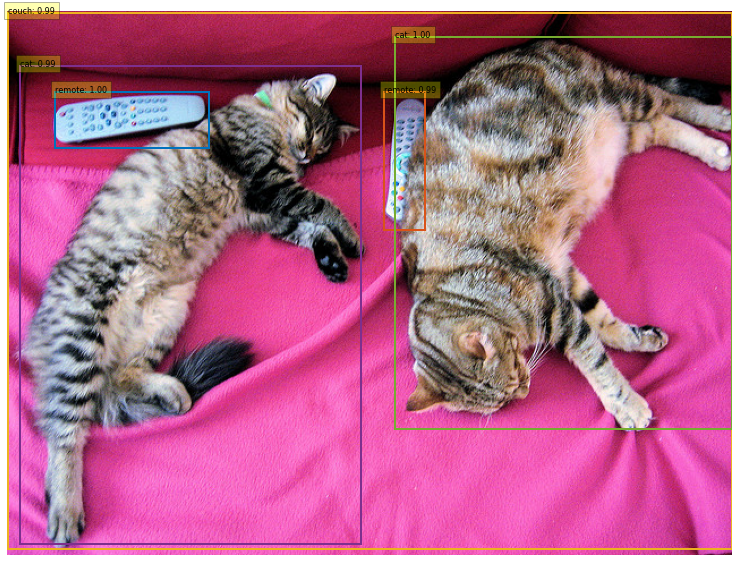

In [12]:
scores, bboxes = detect(im, model)
plot_results(im, scores, bboxes, line_width=2, font_size=8)

## 0928 할 것 : 
--> Attention 연산이 행해지기 전에 decoder의 head를 off하는 방법은?

In [14]:
gen= Generator(model)

### Generator.init()


### Generator.init()
## In DETR.forward(samples: NestedTensor222)
In backbone, Joiner
shape of len(out), shape(out[0]), len(pos),shape(pos):
 1 torch.Size([1, 2048, 25, 34]) 1 torch.Size([1, 256, 25, 34])
len and shape of features in self.backbone(samples) :  1 torch.Size([1, 2048, 25, 34])
src, mask = features[-1].decompose()
shape of src :  torch.Size([1, 2048, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
# START DETR.transformer.forward(self.input_proj(src), mask, ...)
#In Transformer.forward. input : src, mask
shape of src :  torch.Size([1, 256, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
Start Transformer.forward.encoder
Input : src, mask, pos_embed
shape of src : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
shape of pos_embed : torch.Size([850, 1, 256])
End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 25

## In DETR.forward(samples: NestedTensor222)
In backbone, Joiner
shape of len(out), shape(out[0]), len(pos),shape(pos):
 1 torch.Size([1, 2048, 25, 34]) 1 torch.Size([1, 256, 25, 34])
len and shape of features in self.backbone(samples) :  1 torch.Size([1, 2048, 25, 34])
src, mask = features[-1].decompose()
shape of src :  torch.Size([1, 2048, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
# START DETR.transformer.forward(self.input_proj(src), mask, ...)
#In Transformer.forward. input : src, mask
shape of src :  torch.Size([1, 256, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
Start Transformer.forward.encoder
Input : src, mask, pos_embed
shape of src : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
shape of pos_embed : torch.Size([850, 1, 256])
End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : t

End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
In Transformer.decoder.forward(tgt, memory...). shape of output(tgt) : torch.Size([100, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch

/home/jrkim/.conda/envs/jsp_xod/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/jrkim/.conda/envs/jsp_xod/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/jrkim/.conda/envs/jsp_xod/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/jrkim/.conda/envs/jsp_xod/lib/python3.7/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


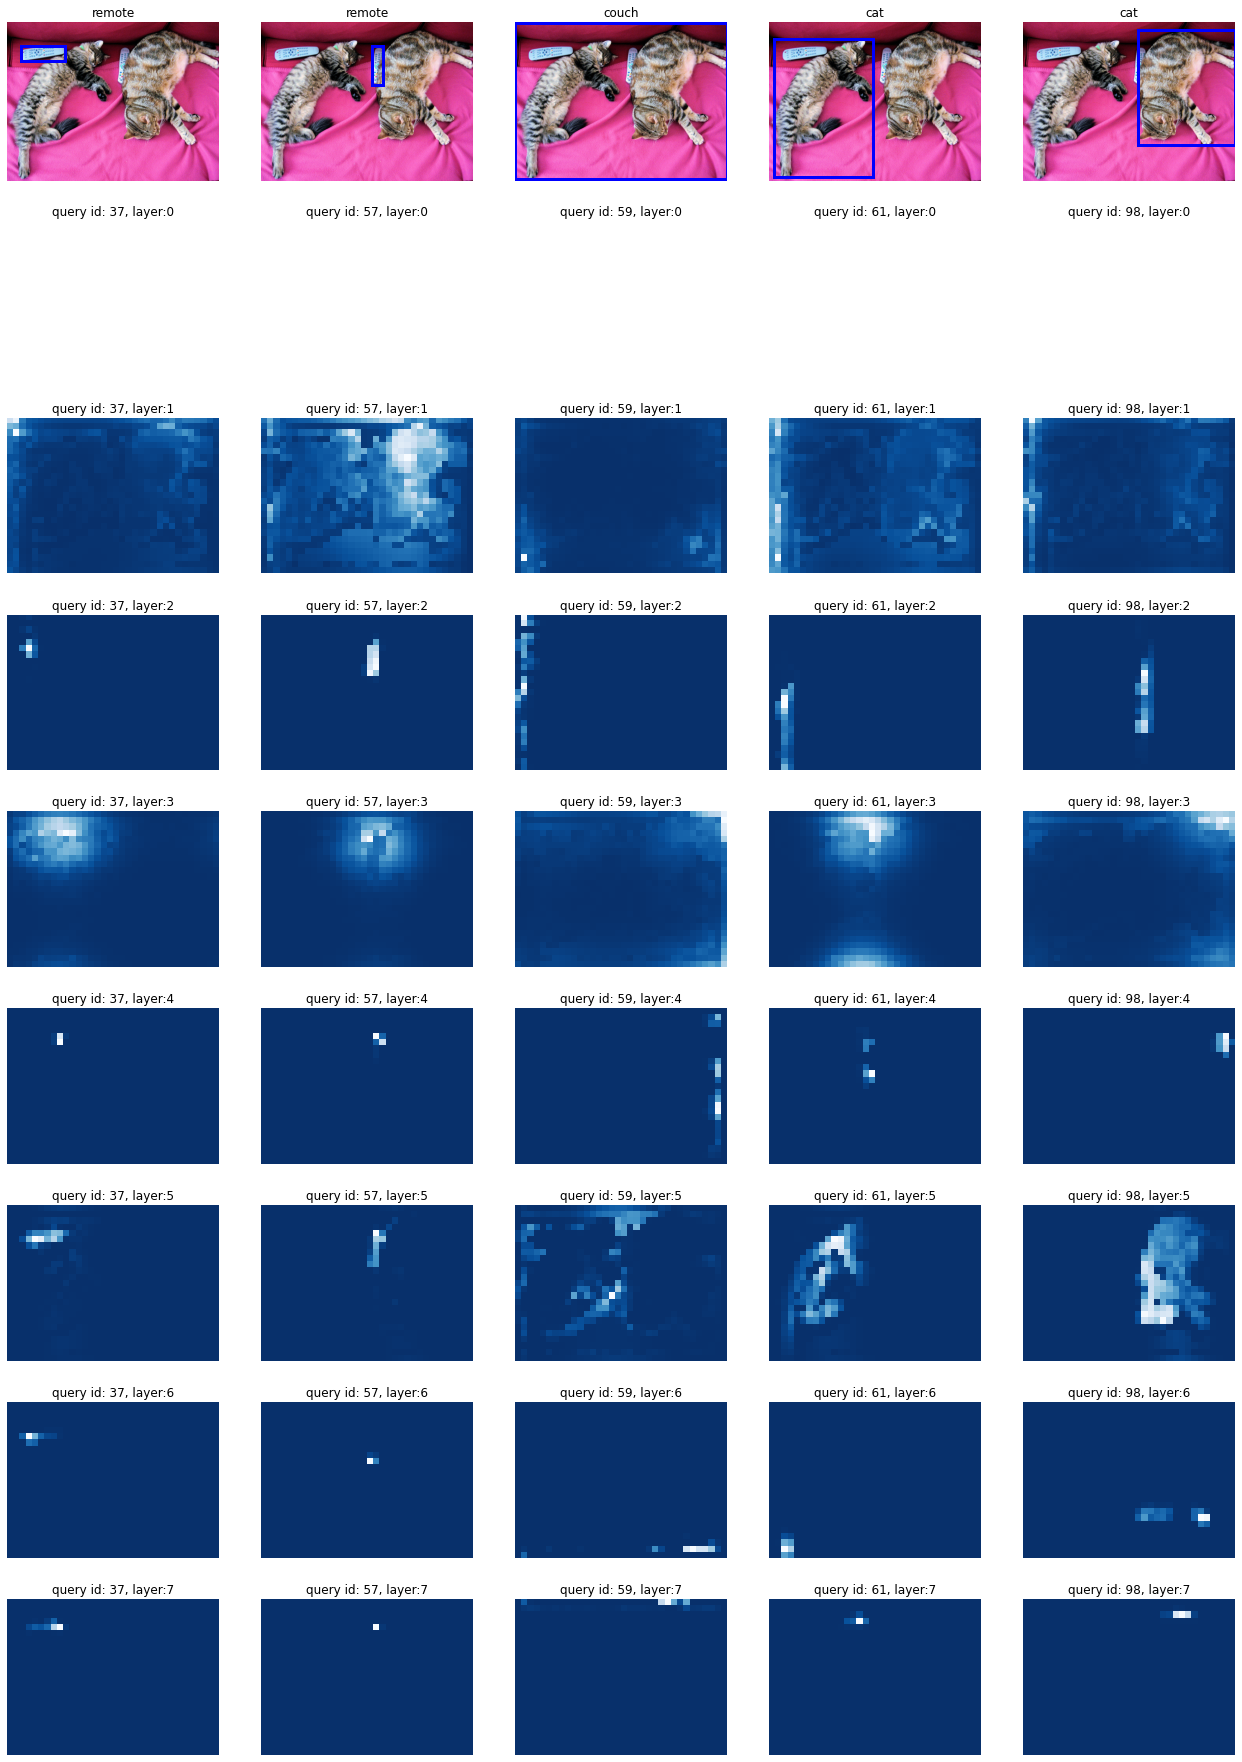

In [26]:

evaluate(model, gen, im, 'cuda', show_all_layers=True, show_raw_attn=True)

## In DETR.forward(samples: NestedTensor222)
In backbone, Joiner
shape of len(out), shape(out[0]), len(pos),shape(pos):
 1 torch.Size([1, 2048, 25, 34]) 1 torch.Size([1, 256, 25, 34])
len and shape of features in self.backbone(samples) :  1 torch.Size([1, 2048, 25, 34])
src, mask = features[-1].decompose()
shape of src :  torch.Size([1, 2048, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
# START DETR.transformer.forward(self.input_proj(src), mask, ...)
#In Transformer.forward. input : src, mask
shape of src :  torch.Size([1, 256, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
Start Transformer.forward.encoder
Input : src, mask, pos_embed
shape of src : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
shape of pos_embed : torch.Size([850, 1, 256])
End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : t

/home/jrkim/.conda/envs/jsp_xod/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  del sys.path[0]


End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
In Transformer.decoder.forward(tgt, memory...). shape of output(tgt) : torch.Size([100, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch.Size([850, 1, 256]) torch.Size([850, 1, 256])
Transformer.decoder.forward(_post). k and value : k, mem_2 torch

## In DETR.forward(samples: NestedTensor222)
In backbone, Joiner
shape of len(out), shape(out[0]), len(pos),shape(pos):
 1 torch.Size([1, 2048, 25, 34]) 1 torch.Size([1, 256, 25, 34])
len and shape of features in self.backbone(samples) :  1 torch.Size([1, 2048, 25, 34])
src, mask = features[-1].decompose()
shape of src :  torch.Size([1, 2048, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
# START DETR.transformer.forward(self.input_proj(src), mask, ...)
#In Transformer.forward. input : src, mask
shape of src :  torch.Size([1, 256, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
Start Transformer.forward.encoder
Input : src, mask, pos_embed
shape of src : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
shape of pos_embed : torch.Size([850, 1, 256])
End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : t

shape of len(out), shape(out[0]), len(pos),shape(pos):
 1 torch.Size([1, 2048, 25, 34]) 1 torch.Size([1, 256, 25, 34])
len and shape of features in self.backbone(samples) :  1 torch.Size([1, 2048, 25, 34])
src, mask = features[-1].decompose()
shape of src :  torch.Size([1, 2048, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
# START DETR.transformer.forward(self.input_proj(src), mask, ...)
#In Transformer.forward. input : src, mask
shape of src :  torch.Size([1, 256, 25, 34])
shape of mask :  torch.Size([1, 25, 34])
Start Transformer.forward.encoder
Input : src, mask, pos_embed
shape of src : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
shape of pos_embed : torch.Size([850, 1, 256])
End Transformer.forward.encoder. output : memory ->  torch.Size([850, 1, 256])
Start Transformer.forward.decoder
Input : tgt, mem1, mask, pos_embed, query_embed...
shape of tgt : torch.Size([100, 1, 256])
shape of mem1 : torch.Size([850, 1, 256])
shape of mask : torch.Size([1, 850])
In 

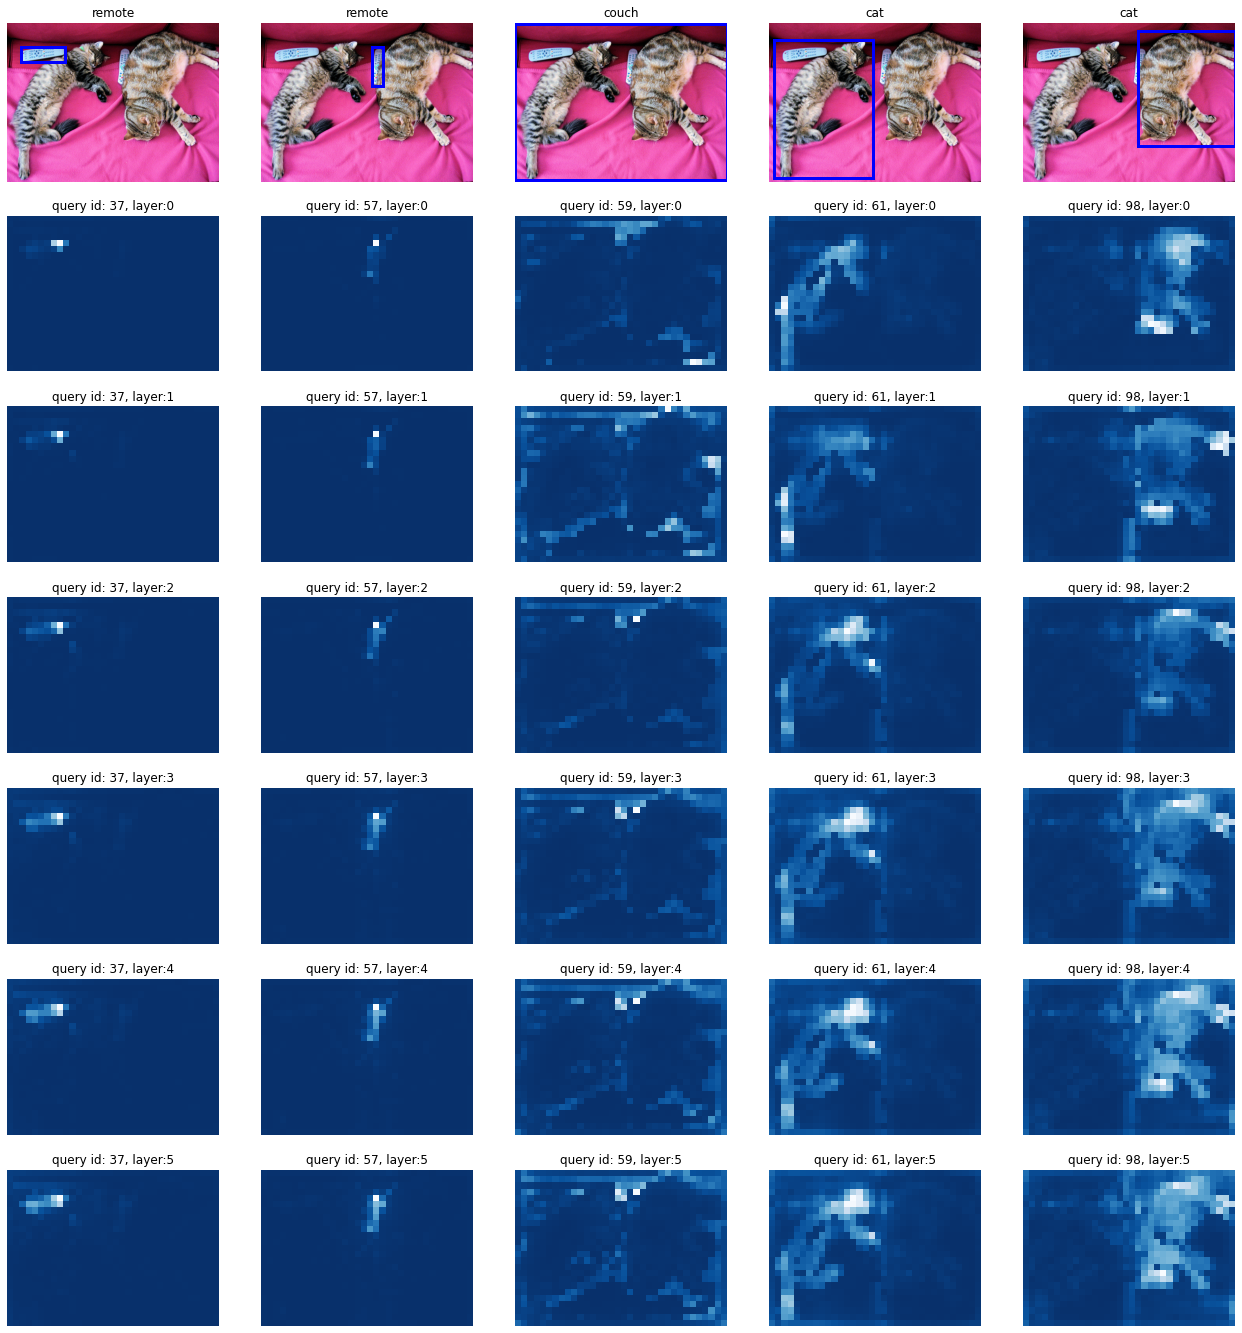

In [15]:
evaluate(model, gen, im, 'cuda', show_all_layers=True)

## 0928~ 끄든 말든 상관 없는 이유 찾기... 
가 아니고 애초에 연산하고 난 다음 꺼봐야 상관 없는게 맞네..

1. 연산 하기 전에 Decoder Off 해보기.  
2. 다양한 조합으로 Decoder Off 해보기.  
그 다음엔 .. 통찰력 발휘해보고, 
3. Decoder의 Probability를 각 head로 전파할 방법, 근거  
4. Backbone까지 Heatmap 확장할 수 있는 방법 찾기, 논문 읽기, 혹은 걍 오리지널로다가..